In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sim_moving import *
from torch.distributions.normal import Normal
import numpy as np
import sys
sys.path.append('/home/hao/Research/probtorch/')
import probtorch

In [74]:
num_tjs = 10000
T = 20
num_digits = 1
step_length = 1.0
frame_size = 64
PATH = '/home/hao/Research/amortized/Moving-MNIST/data/'
mnist_path = '/home/hao/Research/apg_data/mnist/'
simulator = BouncingMNIST(mnist_path=mnist_path, path=PATH, timesteps=T, num_digits=num_digits, step_length=step_length)
# simulator.sim_tjs(num_tjs)

Vs = torch.from_numpy(np.load('./data/tjs_v.npy')).float()
Xs = torch.from_numpy(np.load('./data/tjs_x.npy')).float()
##
NUM_HIDDEN = 16
NUM_STEPS = 1000
BATCH_SIZE = 10
SAMPLE_SIZE = 10
CUDA = torch.cuda.is_available()
num_tjs = Vs.shape[0]
num_batches = int(num_tjs /  BATCH_SIZE)
latent_dim = 8
delta_t = 0.2

In [65]:
# class Enc_tj(nn.Module):
#     def __init__(self, input_dim, num_hidden, latent_dim):
#         super(self.__class__, self).__init__()
#         self.enc_w = nn.Sequential(
#                             nn.Linear(input_dim, latent_dim))
#         self.enc_alpha = nn.Sequential(
#                             nn.Linear(input_dim, latent_dim))
#         self.enc_t = nn.Sequential(
#                             nn.Linear(input_dim, latent_dim))
#     def forward(self, x, v):
#         xv = torch.cat((x, v), -1)
#         w = self.enc_w(xv)
#         alpha = self.enc_alpha(xv)
#         t = self.enc_t(xv)
#         x_pred = (w * torch.sin(x * alpha + t)).sum(-1).unsqueeze(-1)
#         min_ind = torch.argmin(alpha, dim=-1).unsqueeze(-1).detach()
        
# #         alpha_min = torch.gather(alpha, 2, min_ind).detach()
# #         w_min = torch.gather(w, 2, min_ind).detach()
# #         t_min = torch.gather(t, 2, min_ind).detach()
#         v_pred = (alpha * w * torch.cos(x * alpha + t)).sum(-1).unsqueeze(-1).detach().sign() * v.abs()
#         return x_pred, v_pred, alpha, w, t

In [66]:
class Enc_tj(nn.Module):
    def __init__(self, input_dim, num_hidden, latent_dim, T, delta_t, CUDA):
        super(self.__class__, self).__init__()
        self.enc_w = nn.Sequential(
                            nn.Linear(input_dim, latent_dim))
        self.enc_alpha = nn.Sequential(
                            nn.Linear(input_dim, latent_dim))
        self.enc_t = nn.Sequential(
                            nn.Linear(input_dim, latent_dim))
        
        
        self.ts =  torch.arange(0, T*delta_t, delta_t).float()
        if CUDA:
            self.ts = self.ts.cuda()
    def forward(self, x):
        B, _ = x.shape
        w = self.enc_w(x)
        alpha = self.enc_alpha(x)
        phase = self.enc_t(x)
        x_pred = (w.unsqueeze(1).repeat(1, T, 1) * torch.sin(torch.bmm(self.ts.repeat(B, 1).unsqueeze(-1), alpha.unsqueeze(1)) + phase.unsqueeze(1).repeat(1, T, 1))).sum(-1)
#         min_ind = torch.argmin(alpha, dim=-1).unsqueeze(-1).detach()
        
#         alpha_min = torch.gather(alpha, 2, min_ind).detach()
#         w_min = torch.gather(w, 2, min_ind).detach()
#         t_min = torch.gather(t, 2, min_ind).detach()
#         v_pred = (alpha * w * torch.cos(x * alpha + t)).sum(-1).unsqueeze(-1).detach().sign() * v.abs()
        return x_pred

In [67]:
# class Enc_tj(nn.Module):
#     def __init__(self, num_hidden):
#         super(self.__class__, self).__init__()
#         self.enc_hidden = nn.Sequential(
#                             nn.Linear(4, num_hidden),
#                             nn.Linear(num_hidden, 2),
#                             nn.Tanh())
#     def forward(self, x, v):
#         v_new = self.enc_hidden(torch.cat((x, v), -1))
#         x_new = x + 0.2 * v_new
#         return x_new, v_new

In [68]:
enc = Enc_tj(input_dim=T, num_hidden=NUM_HIDDEN, latent_dim=latent_dim, T=T, delta_t=delta_t, CUDA=CUDA)
enc.cuda()
optimizer =  torch.optim.Adam(list(enc.parameters()),lr=1e-5, betas=(0.9, 0.99))

In [69]:
# for i in range(NUM_STEPS):
#     optimizer.zero_grad()
#     indices = torch.randperm(num_tjs)
#     LOSS = 0.0
#     for b in range(num_batches):
#         b_ind = indices[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
#         xb = Xs[b_ind].cuda()[:, :, 0].unsqueeze(-1)
#         vb = Vs[b_ind].cuda()[:, :, 0].unsqueeze(-1)
#         for t in range(T-1):
#             if t == 0:
#                 x_pred, v_pred = enc(xb[:, t, 0].unsqueeze(-1), vb[:, t, 0].unsqueeze(-1))
#             else:
#                 x_pred, v_pred = enc(x_pred, v_pred)
#             loss = ((x_pred - xb[:, t+1, 0])**2).sum(-1).mean()
#         loss.backward()
#         optimizer.step()
#         LOSS += loss
#     %time print('iter=%d, loss=%.6f' % (i, LOSS / num_batches))

In [70]:
for i in range(NUM_STEPS):
    optimizer.zero_grad()
    indices = torch.randperm(num_tjs)
    LOSS = 0.0
    for b in range(num_batches):
        b_ind = indices[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
        xb = Xs[b_ind].cuda()[:, :, 0] ## B * T
#         xb.requires_grad_(True)
#         vb = Vs[b_ind].cuda()[:,:, 0]
        x_pred = enc(xb)
        loss = ((x_pred - xb)**2).sum(-1).mean()
        loss.backward()
#         v_pred = (torch.sign(xb.grad) * vb.abs()).detach()
        optimizer.step()
        LOSS += loss
        
    %time print('iter=%d, loss=%.6f' % (i, LOSS / num_batches))

iter=0, loss=10.981545
CPU times: user 0 ns, sys: 962 µs, total: 962 µs
Wall time: 968 µs
iter=1, loss=6.773578
CPU times: user 231 µs, sys: 12 µs, total: 243 µs
Wall time: 248 µs
iter=2, loss=4.433617
CPU times: user 473 µs, sys: 23 µs, total: 496 µs
Wall time: 463 µs
iter=3, loss=2.955575
CPU times: user 1.65 ms, sys: 0 ns, total: 1.65 ms
Wall time: 1.6 ms
iter=4, loss=2.144525
CPU times: user 654 µs, sys: 32 µs, total: 686 µs
Wall time: 655 µs
iter=5, loss=1.650230
CPU times: user 255 µs, sys: 13 µs, total: 268 µs
Wall time: 283 µs
iter=6, loss=1.257206
CPU times: user 391 µs, sys: 19 µs, total: 410 µs
Wall time: 417 µs
iter=7, loss=0.938890
CPU times: user 1.01 ms, sys: 49 µs, total: 1.05 ms
Wall time: 1.02 ms
iter=8, loss=0.730393
CPU times: user 183 µs, sys: 9 µs, total: 192 µs
Wall time: 197 µs
iter=9, loss=0.604006
CPU times: user 247 µs, sys: 12 µs, total: 259 µs
Wall time: 264 µs
iter=10, loss=0.525012
CPU times: user 427 µs, sys: 20 µs, total: 447 µs
Wall time: 454 µs
iter=1

KeyboardInterrupt: 

In [ ]:
# optimizer.zero_grad()
# indices = torch.randperm(num_tjs)
# b_ind = indices[0*BATCH_SIZE:(0+1)*BATCH_SIZE]
# xb = Xs[b_ind].cuda()[:, :-1, 0].unsqueeze(-1)
# xb.requires_grad_(True)

# vb = Vs[b_ind].cuda()[:,:-1, 0].unsqueeze(-1)
# x_pred = enc(xb, vb)
# loss = ((x_pred - xb)**2).sum(-1).mean()
# loss.backward()

In [55]:
s = 4
optimizer.zero_grad()
xb = Xs[s:(s+1)].cuda()[:,:, 0]
# xb.requires_grad_(True)
x_pred = enc(xb)
# x_pred.backward()
# v_pred = (torch.sign(xb.grad) * vb.abs()).detach()
# x_pred = x_pred.squeeze(0)

In [ ]:
P = 20
XP = []
VP = []
xp = x_pred[0, 0, :].unsqueeze(0).unsqueeze(0)
# vp = v_pred[0, -1, :].unsqueeze(0).unsqueeze(0)
vp = vb[0, 0, :].unsqueeze(0).unsqueeze(0)
VP.append(vp.unsqueeze(0))
XP.append(xp.unsqueeze(0))

for p in range(P):
    xp, vp, _, _, _ = enc(xp,vp)
    XP.append(xp.unsqueeze(0))
    VP.append(vp.unsqueeze(0))
VP = torch.cat(VP, 0).squeeze(1)
XP = torch.cat(XP, 0).squeeze(1)

In [58]:
xb.shape

torch.Size([1, 20])

In [60]:
# space = torch.linspace(0, 20, 200)
# wave = (w.cpu()[0, 0, :] * torch.sin(space.unsqueeze(-1).repeat(1, 8) * alpha.cpu()[0, 0, :] + t.cpu()[0, 0, :])).sum(-1).unsqueeze(-1)
# grad = (alpha.cpu()[0, 0, :] * w.cpu()[0, 0, :] * torch.cos(space.unsqueeze(-1).repeat(1, 8) * alpha.cpu()[0, 0, :] + t.cpu()[0, 0, :])).sum(-1).unsqueeze(-1).detach().sign() * vb[0, 0, 0].cpu().abs()

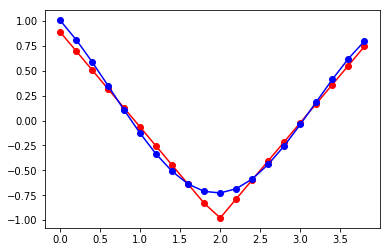

In [73]:
s = 19
optimizer.zero_grad()
xb = Xs[s:(s+1)].cuda()[:,:, 0]
# xb.requires_grad_(True)
x_pred = enc(xb)

x_plt = np.arange(0, 0.2*20, 0.2)
plt.plot(x_plt, xb[0].cpu().data.numpy(), c='r', marker='o')
plt.plot(x_plt, x_pred[0].cpu().data.numpy(), c='b', marker='o')
# plt.plot(x_plt, XP[:, 0, 0].cpu().data.numpy(), c='m')
# plt.plot(space.data.numpy(), wave.data.numpy())
# plt.plot(space.data.numpy(), grad.data.numpy(), marker='o')

In [ ]:
plt.scatter(xb[0, 1:, 0].cpu().data.numpy(), xb[0, 1:, 1].cpu().data.numpy(), c='r')
# plt.scatter(x_pred[:, 0].cpu().data.numpy(), x_pred[:, 1].cpu().data.numpy(), c='b')
# plt.scatter(XP[:, 0].cpu().data.numpy(), XP[:, 1].cpu().data.numpy(), c='m')

In [ ]:
list(enc.parameters())

In [ ]:
x_plt.shape

In [ ]:
xb.shape